In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xverse
from xverse.feature_subset import FeatureSubset
from xverse.transformer import MonotonicBinning
import sklearn
from sklearn.model_selection import train_test_split
from xverse.transformer import WOE
import statsmodels.api as sm
# Importing LogisticRegression and metrics from sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Importing required libraries
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import data

crt_br=pd.read_csv('Credit Bureau data.csv')
df_dmg=pd.read_csv('Demographic data.csv')

#### Demographic data EDA

In [3]:
#Column renaming
df_dmg.rename(columns={'Marital Status (at the time of application)':'Marital_Status',
                       'Profession ':'Profession'},inplace='True')

In [4]:
#Analysing the data info
df_dmg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71295 entries, 0 to 71294
Data columns (total 12 columns):
Application ID                       71295 non-null int64
Age                                  71295 non-null int64
Gender                               71293 non-null object
Marital_Status                       71289 non-null object
No of dependents                     71292 non-null float64
Income                               71295 non-null float64
Education                            71176 non-null object
Profession                           71281 non-null object
Type of residence                    71287 non-null object
No of months in current residence    71295 non-null int64
No of months in current company      71295 non-null int64
Performance Tag                      69870 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 6.5+ MB


In [5]:
#Calculating null count in each column
df_dmg.isnull().sum()

Application ID                          0
Age                                     0
Gender                                  2
Marital_Status                          6
No of dependents                        3
Income                                  0
Education                             119
Profession                             14
Type of residence                       8
No of months in current residence       0
No of months in current company         0
Performance Tag                      1425
dtype: int64

In [6]:
#Fetching percentiles of each column
df_dmg.describe(percentiles=[0.2,0.5,0.75,0.95])

,Application ID,Age,No of dependents,Income,No of months in current residence,No of months in current company,Performance Tag
count,7.129500e+04,71295.000000,71292.000000,71295.000000,71295.000000,71295.000000,69870.000000
mean,4.989601e+08,44.943039,2.865188,27.195224,34.563420,33.958244,0.042193
std,2.885905e+08,9.939211,1.382319,15.514626,36.759758,20.410824,0.201030
min,1.004500e+05,-3.000000,1.000000,-0.500000,6.000000,3.000000,0.000000
20%,1.990307e+08,36.000000,1.000000,11.000000,6.000000,13.000000,0.000000
50%,4.975698e+08,45.000000,3.000000,27.000000,11.000000,34.000000,0.000000
75%,7.495868e+08,53.000000,4.000000,40.000000,60.000000,51.000000,0.000000
95%,9.492921e+08,62.000000,5.000000,54.000000,110.000000,68.000000,0.000000
max,1.000084e+09,65.000000,5.000000,60.000000,126.000000,133.000000,1.000000


In [7]:
dem_cols=df_dmg.columns
dem_cols

Index(['Application ID', 'Age', 'Gender', 'Marital_Status', 'No of dependents',
       'Income', 'Education', 'Profession', 'Type of residence',
       'No of months in current residence', 'No of months in current company',
       'Performance Tag'],
      dtype='object')

#### Analysis of each variable using plots

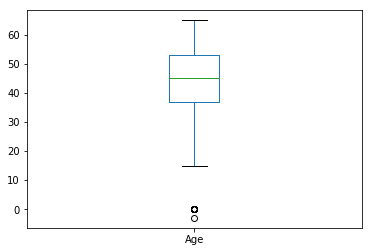

In [8]:
#Age boxplot
df_dmg.Age.plot(kind='box')

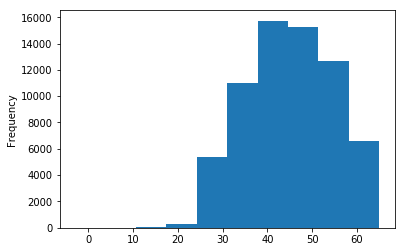

In [9]:
# Histogram of age based by filter on performance tag
df_dmg[df_dmg['Performance Tag']==0]['Age'].plot(kind='hist')

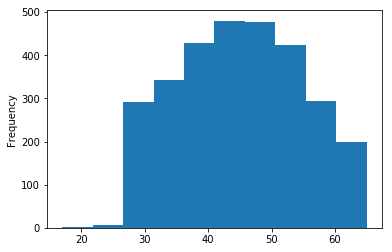

In [10]:
df_dmg[df_dmg['Performance Tag']==1]['Age'].plot(kind='hist')

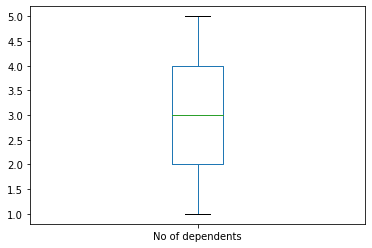

In [12]:
#No of dependents box plot
df_dmg['No of dependents'].plot(kind='box')

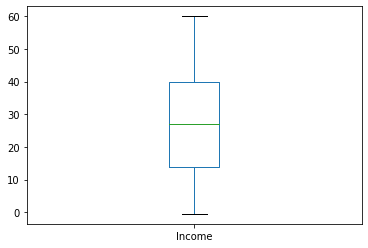

In [13]:
# Income boxplot
df_dmg['Income'].plot(kind='box')

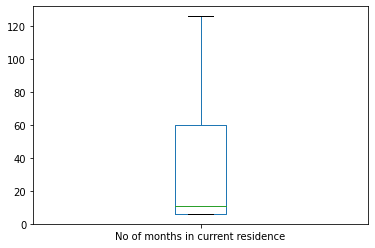

In [14]:
#No of months in current residence boxplot
df_dmg['No of months in current residence'].plot(kind='box')

In [11]:
df_dmg[df_dmg['No of months in current company']>100]

,Application ID,Age,Gender,Marital_Status,No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,Performance Tag
15,268129376,45,F,Married,5.0,44.0,Bachelor,SAL,Rented,81,123,0.0
810,788141600,52,F,Married,1.0,5.0,Masters,SAL,Rented,6,128,0.0
11811,700748782,56,M,Married,5.0,4.5,Professional,SE_PROF,Rented,6,133,0.0
27571,457161315,47,M,Married,5.0,10.0,Bachelor,SAL,Company provided,6,121,0.0
34070,825597539,52,M,Married,2.0,14.0,Masters,SE_PROF,Rented,6,126,0.0
50947,862310213,46,M,Married,2.0,19.0,Professional,SE,Owned,66,105,0.0


In [12]:
#To remove outilers suppressing the higher values
df_dmg['No of months in current company']=df_dmg['No of months in current company'].map(lambda x:100 if x>100 else x)

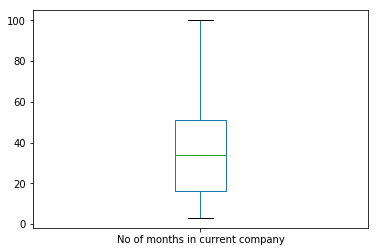

In [13]:
df_dmg['No of months in current company'].plot(kind='box')

#### Categorical variables frequency analysis

In [14]:
#Gender frequency based on target variable
df_dmg.groupby(['Gender','Performance Tag'])['Performance Tag'].count()

Gender  Performance Tag
F       0.0                15788
        1.0                  718
M       0.0                51132
        1.0                 2230
Name: Performance Tag, dtype: int64

In [15]:
#Marital_Status frequency
df_dmg.groupby(['Marital_Status','Performance Tag'])['Performance Tag'].count()

Marital_Status  Performance Tag
Married         0.0                57044
                1.0                 2503
Single          0.0                 9872
                1.0                  445
Name: Performance Tag, dtype: int64

In [16]:
#Education Frequency
df_dmg.groupby(['Education','Performance Tag'])['Performance Tag'].count()

Education     Performance Tag
Bachelor      0.0                16560
              1.0                  742
Masters       0.0                22483
              1.0                  998
Others        0.0                  111
              1.0                    8
Phd           0.0                 4280
              1.0                  184
Professional  0.0                23375
              1.0                 1011
Name: Performance Tag, dtype: int64

In [17]:
#Profession Frequency
df_dmg.groupby(['Profession','Performance Tag'])['Performance Tag'].count()

Profession  Performance Tag
SAL         0.0                38045
            1.0                 1629
SE          0.0                13285
            1.0                  642
SE_PROF     0.0                15579
            1.0                  677
Name: Performance Tag, dtype: int64

In [18]:
#Type of residence frequency
df_dmg.groupby(['Type of residence','Performance Tag'])['Performance Tag'].count()

Type of residence    Performance Tag
Company provided     0.0                 1530
                     1.0                   73
Living with Parents  0.0                 1698
                     1.0                   80
Others               0.0                  193
                     1.0                    5
Owned                0.0                13410
                     1.0                  593
Rented               0.0                50083
                     1.0                 2197
Name: Performance Tag, dtype: int64

#### Data Cleaning demographic data

In [19]:
#Age cleansing as negative age is not possible
df_dmg['Age']=df_dmg['Age'].map(lambda x:np.nan if x<=0 else x )

In [20]:
df_dmg.isnull().sum()

Application ID                          0
Age                                    20
Gender                                  2
Marital_Status                          6
No of dependents                        3
Income                                  0
Education                             119
Profession                             14
Type of residence                       8
No of months in current residence       0
No of months in current company         0
Performance Tag                      1425
dtype: int64

In [21]:
df_dmg[df_dmg['Marital_Status'].isnull()]

,Application ID,Age,Gender,Marital_Status,No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,Performance Tag
6380,109442654,38.0,M,NaN,2.0,24.0,Professional,SAL,Company provided,117,3,0.0
35519,30223535,43.0,F,NaN,3.0,41.0,Masters,SE_PROF,Rented,6,12,0.0
48404,930789432,47.0,F,NaN,5.0,8.0,Masters,SAL,Owned,23,59,0.0
50734,822575718,35.0,M,NaN,4.0,20.0,Bachelor,SAL,Rented,59,20,0.0
59295,355703957,48.0,M,NaN,1.0,4.5,Bachelor,SAL,Owned,14,26,0.0
68043,852875477,NaN,M,NaN,1.0,5.0,Phd,NaN,Owned,14,31,0.0


In [22]:
#Filtering the records which have performance tage as null
df_dmg=df_dmg[df_dmg['Performance Tag'].notnull()]

In [23]:
# Null count column wise
df_dmg.isnull().sum()

Application ID                         0
Age                                   20
Gender                                 2
Marital_Status                         6
No of dependents                       3
Income                                 0
Education                            118
Profession                            13
Type of residence                      8
No of months in current residence      0
No of months in current company        0
Performance Tag                        0
dtype: int64

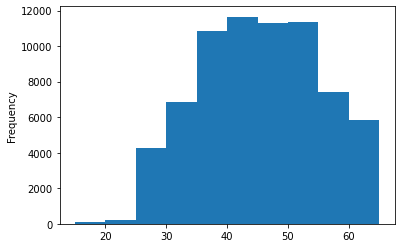

In [28]:
#Hist plot for Age
df_dmg['Age'].plot(kind='hist')

In [24]:
#Calculating mean and median for age column
print('mean',df_dmg['Age'].mean())
print('median',df_dmg['Age'].median())

mean 45.00850393700787
median 45.0


In [25]:
# Substituting nulls with mean for age column
df_dmg['Age']=df_dmg['Age'].map(lambda x:45 if (np.isnan(x)) else x )

In [26]:
#Calculating mean and median for No of dependents column
print('mean',df_dmg['No of dependents'].mean())
print('median',df_dmg['No of dependents'].median())

mean 2.8595617387321624
median 3.0


In [27]:
# Substituting the highest mode value for nulls in gender variable
df_dmg['Gender']=df_dmg['Gender'].map(lambda x:'M' if pd.isnull(x) else x )
df_dmg['Marital_Status']=df_dmg['Marital_Status'].map(
    lambda x:'Married' if pd.isnull(x) else x )

In [28]:
## Substituting nulls with mean for No of dependents column
df_dmg['No of dependents']=df_dmg['No of dependents'].map(lambda x:3 if (np.isnan(x)) else x )

In [29]:
#Creating a new level for nulls in the below variables
df_dmg['Education']=df_dmg['Education'].map(lambda x:'Others' if pd.isnull(x) else x )
df_dmg['Profession']=df_dmg['Profession'].map(lambda x:'Other' if pd.isnull(x) else x )
df_dmg['Type of residence']=df_dmg['Type of residence'].map(lambda x:'Others' if pd.isnull(x) else x )

In [35]:
df_dmg.head()

,Application ID,Age,Gender,Marital_Status,No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,Performance Tag
0,954457215,48.0,F,Married,2.0,40.0,Bachelor,SAL,Rented,113,56,0.0
1,432830445,31.0,M,Married,4.0,55.0,Professional,SE_PROF,Rented,112,46,0.0
2,941387308,32.0,M,Single,2.0,46.0,Bachelor,SE_PROF,Rented,104,49,0.0
3,392161677,43.0,M,Married,1.0,53.0,Bachelor,SE,Rented,94,53,0.0
4,182011211,35.0,F,Married,5.0,44.0,Professional,SAL,Rented,112,43,0.0


#### Credit Bureau data Analysis

In [30]:
# Calculating null values in each column
crt_br.isnull().sum()

Application ID                                                        0
No of times 90 DPD or worse in last 6 months                          0
No of times 60 DPD or worse in last 6 months                          0
No of times 30 DPD or worse in last 6 months                          0
No of times 90 DPD or worse in last 12 months                         0
No of times 60 DPD or worse in last 12 months                         0
No of times 30 DPD or worse in last 12 months                         0
Avgas CC Utilization in last 12 months                             1058
No of trades opened in last 6 months                                  1
No of trades opened in last 12 months                                 0
No of PL trades opened in last 6 months                               0
No of PL trades opened in last 12 months                              0
No of Inquiries in last 6 months (excluding home & auto loans)        0
No of Inquiries in last 12 months (excluding home & auto loans) 

#### Performing EDA

#### Using boxplot and solving the outliers issue

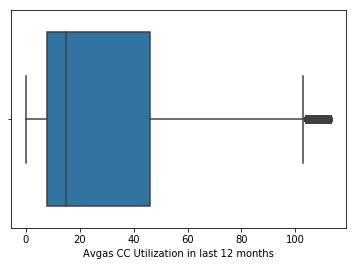

In [31]:
#Boxplot for Avgas CC Utilization in last 12 months
sns.boxplot(x='Avgas CC Utilization in last 12 months', data=crt_br)
plt.show()

In [32]:
#Suppressing the high values to solve the outlier issue
crt_br['Avgas CC Utilization in last 12 months'][crt_br['Avgas CC Utilization in last 12 months']>104]=104

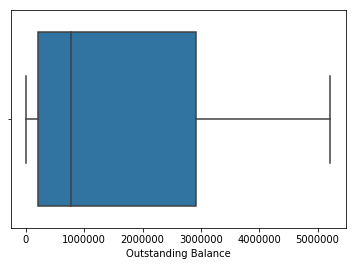

In [33]:
#Box plot for Outstanding Balance
sns.boxplot(x='Outstanding Balance', data=crt_br)
plt.show()

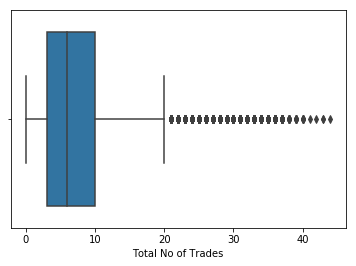

In [34]:
#Total No of Trades
sns.boxplot(x='Total No of Trades', data=crt_br)
plt.show()

In [35]:
#Suppressing the outliers
crt_br['Total No of Trades'][crt_br['Total No of Trades']>22]=22

In [36]:
# Drop rows where performance tag value is null

crd_buro=crt_br[crt_br['Performance Tag'].notnull() ]


In [37]:
crd_buro.isnull().sum()

Application ID                                                        0
No of times 90 DPD or worse in last 6 months                          0
No of times 60 DPD or worse in last 6 months                          0
No of times 30 DPD or worse in last 6 months                          0
No of times 90 DPD or worse in last 12 months                         0
No of times 60 DPD or worse in last 12 months                         0
No of times 30 DPD or worse in last 12 months                         0
Avgas CC Utilization in last 12 months                             1023
No of trades opened in last 6 months                                  1
No of trades opened in last 12 months                                 0
No of PL trades opened in last 6 months                               0
No of PL trades opened in last 12 months                              0
No of Inquiries in last 6 months (excluding home & auto loans)        0
No of Inquiries in last 12 months (excluding home & auto loans) 

In [38]:
crd_buro.head()

,Application ID,No of times 90 DPD or worse in last 6 months,No of times 60 DPD or worse in last 6 months,No of times 30 DPD or worse in last 6 months,No of times 90 DPD or worse in last 12 months,No of times 60 DPD or worse in last 12 months,No of times 30 DPD or worse in last 12 months,Avgas CC Utilization in last 12 months,No of trades opened in last 6 months,No of trades opened in last 12 months,No of PL trades opened in last 6 months,No of PL trades opened in last 12 months,No of Inquiries in last 6 months (excluding home & auto loans),No of Inquiries in last 12 months (excluding home & auto loans),Presence of open home loan,Outstanding Balance,Total No of Trades,Presence of open auto loan,Performance Tag
0,954457215,0,0,0,0,0,0,4.0,1.0,2,0,0,0,0,1.0,2999395.0,4,0,0.0
1,432830445,0,0,0,0,0,0,3.0,1.0,2,0,0,0,0,0.0,3078.0,5,0,0.0
2,941387308,0,0,0,0,0,0,7.0,0.0,0,0,0,0,0,1.0,3004972.0,2,0,0.0
3,392161677,0,0,0,0,0,0,11.0,1.0,1,0,0,0,0,1.0,3355373.0,4,1,0.0
4,182011211,0,0,0,0,0,0,12.0,0.0,1,0,0,0,0,1.0,3014283.0,4,0,0.0


## Data Modelling with Demographic Data Set

In [45]:
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xverse.transformer import WOE

In [46]:
# Putting feature variable to X
X = df_dmg.drop(['Performance Tag'],axis=1)
X = X.drop(['Application ID'],axis=1)

# Putting response variable to y
y = df_dmg['Performance Tag']

In [47]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X[X.columns],y, train_size=0.7,test_size=0.3,random_state=1000)

In [48]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

48909
48909
20961
20961


In [49]:
#Fitting WOE transformation to train data
clf = WOE()
clf.fit(X_train[X_train.columns], y_train)

/home/sam/anaconda3/lib/python3.7/site-packages/xverse/transformer/_woe.py:224: RuntimeWarning: divide by zero encountered in log
  temp_woe['WOE'] = np.log(temp_woe['Event_Distribution']/temp_woe['Non_Event_Distribution'])


WOE(exclude_features=None, feature_names='all', mono_cardinality_cutoff=5,
    mono_custom_binning={'Age': array([15., 40., 50., 65.]),
                         'Income': array([-0.5, 18. , 35. , 60. ]),
                         'No of dependents': array([1., 2., 3., 4., 5.]),
                         'No of months in current company': array([  3.,  23.,  45., 100.]),
                         'No of months in current residence': array([  6.,  43., 126.])},
    mono_feature_names='all', mono_force_bins=3,...
                                                    Interval(43.0, 126.0, closed='right'): 0.07334606788974084},
              'Profession': {'Other': 0.0, 'SAL': -0.033904303776385966,
                             'SE': 0.11120012505360347,
                             'SE_PROF': -0.01838798361491523},
              'Type of residence': {'Company provided': 0.05618204542716653,
                                    'Living with Parents': 0.027688324639906968,
                        

In [50]:
clf.woe_bins

{'Age': {Interval(14.999, 40.0, closed='right'): 0.04800196851365128,
  Interval(40.0, 50.0, closed='right'): -0.03180495592944252,
  Interval(50.0, 65.0, closed='right'): -0.022295497714173728},
 'Education': {'Bachelor': 0.032885811852124795,
  'Masters': 0.006852110799291663,
  'Others': 0.3767586691934203,
  'Phd': -0.020076893580083608,
  'Professional': -0.03155767101419418},
 'Gender': {'F': 0.039355598539336276, 'M': -0.012475043962838986},
 'Income': {Interval(-0.501, 18.0, closed='right'): 0.1970947326857041,
  Interval(18.0, 35.0, closed='right'): -0.0004132862374339001,
  Interval(35.0, 60.0, closed='right'): -0.24191040283246784},
 'Marital_Status': {'Married': -0.0009984927471171172,
  'Single': 0.005717955452654037},
 'No of dependents': {1.0: 0.0675901288172587,
  2.0: -0.10528355376000362,
  3.0: 0.06859775949644505,
  4.0: -0.016431487720409723,
  5.0: -0.03983907100676524},
 'No of months in current company': {Interval(2.999, 23.0, closed='right'): 0.1708444356017183

In [51]:
#Applying WOE tranformation to train and test data
df_train_woe=clf.transform(X_train)
df_test_woe=clf.transform(X_test)

In [52]:
#looking at the information value matrix of the variable
clf.iv_df

,Variable_Name,Information_Value
3,Income,0.031590
6,No of months in current company,0.017749
5,No of dependents,0.004705
8,Profession,0.003324
7,No of months in current residence,0.002780
0,Age,0.001316
1,Education,0.001224
9,Type of residence,0.000731
2,Gender,0.000491
4,Marital_Status,0.000006


##### The variable that are least important are age,marital status and type of residance
##### now lets look at the model based on these variable see the predictive power of demografic data

In [53]:
X_train=df_train_woe

In [54]:
#looking at the p values of all the features in the model
x_train=sm.add_constant(X_train[X_train.columns])
reg_mod=sm.GLM(y_train,x_train,family=sm.families.Binomial(),class_weight='balanced')
reg_mod.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance Tag   No. Observations:                48909
Model:                            GLM   Df Residuals:                    48898
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8557.8
Date:                Mon, 13 Apr 2020   Deviance:                       17116.
Time:                        21:23:21   Pearson chi2:                 4.89e+04
No. Iterations:                     6   Covariance Type:             nonrobust
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1113      0.023   -137.928      0.000      -3.156      -3.067
Age                                   0.4837      0.635      0.761      0.447      -0.762       1.729
Gender                                1.0499      1.005      1.044      0.296      -0.921       3.020
Marital_Status                       -3.2149      9.602     -0.335      0.738     -22.035      15.605
No of dependents                      0.9458      0.328      2.882      0.004       0.303       1.589
Income                                1.0257      0.129      7.955      0.000       0.773       1.278
Education                             0.9821      0.613      1.603      0.109      -0.219       2.183
Profession                            1.0129      0.382      2.651      0.008       0.264       1.762
Type of residence                     0.9616      0.874      1.100      0.271      -0.751       2.674
No of months in current residence     0.5128      0.425      1.208      0.227      -0.319       1.345
No of months in current company       1.0836      0.167      6.497      0.000       0.757       1.411
=====================================================================================================
"""

In [55]:
tar_cols=list(X_train.columns)

In [56]:
#looking at VIF of model 
vif=pd.DataFrame()
vif['Features']=X_train[tar_cols].columns
vif['VIF']=[variance_inflation_factor(X_train[tar_cols].values,i) for i in range(X_train[tar_cols].shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif

,Features,VIF
0,Age,1.07
1,Gender,1.00
2,Marital_Status,1.05
3,No of dependents,1.00
4,Income,1.02
5,Education,1.00
6,Profession,1.00
7,Type of residence,1.00
8,No of months in current residence,1.01
9,No of months in current company,1.01


In [57]:
#Removing the Marital_Status due to high p value
tar_cols=[x for x in tar_cols if x not in ['Marital_Status']]

In [58]:
#looking at VIF of model 
vif=pd.DataFrame()
vif['Features']=X_train[tar_cols].columns
vif['VIF']=[variance_inflation_factor(X_train[tar_cols].values,i) for i in range(X_train[tar_cols].shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif

,Features,VIF
0,Age,1.02
1,Gender,1.00
2,No of dependents,1.00
3,Income,1.02
4,Education,1.00
5,Profession,1.00
6,Type of residence,1.00
7,No of months in current residence,1.01
8,No of months in current company,1.01


In [59]:
#looking at the p values of the remaining features in the model
x_train=sm.add_constant(X_train[tar_cols])
reg_mod=sm.GLM(y_train,x_train,family=sm.families.Binomial(),class_weigth='balanced')
reg_mod.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance Tag   No. Observations:                48909
Model:                            GLM   Df Residuals:                    48899
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8557.8
Date:                Mon, 13 Apr 2020   Deviance:                       17116.
Time:                        21:23:50   Pearson chi2:                 4.89e+04
No. Iterations:                     6   Covariance Type:             nonrobust
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1113      0.023   -137.929      0.000      -3.156      -3.067
Age                                   0.4377      0.621      0.705      0.481      -0.779       1.654
Gender                                1.0479      1.005      1.042      0.297      -0.923       3.018
No of dependents                      0.9445      0.328      2.879      0.004       0.301       1.587
Income                                1.0254      0.129      7.953      0.000       0.773       1.278
Education                             0.9827      0.613      1.604      0.109      -0.218       2.183
Profession                            1.0128      0.382      2.650      0.008       0.264       1.762
Type of residence                     0.9567      0.873      1.096      0.273      -0.755       2.668
No of months in current residence     0.5133      0.425      1.209      0.227      -0.319       1.345
No of months in current company       1.0838      0.167      6.498      0.000       0.757       1.411
=====================================================================================================
"""

In [60]:
#Removing the Age due to high p value
tar_cols=[x for x in tar_cols if x not in ['Age']]

In [61]:
#looking at the p values of the remaining features in the model
x_train=sm.add_constant(X_train[tar_cols])
reg_mod=sm.GLM(y_train,x_train,family=sm.families.Binomial(),class_weigth='balanced')
reg_mod.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance Tag   No. Observations:                48909
Model:                            GLM   Df Residuals:                    48900
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8558.1
Date:                Mon, 13 Apr 2020   Deviance:                       17116.
Time:                        21:24:02   Pearson chi2:                 4.89e+04
No. Iterations:                     6   Covariance Type:             nonrobust
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1113      0.023   -137.933      0.000      -3.156      -3.067
Gender                                1.0442      1.005      1.039      0.299      -0.926       3.015
No of dependents                      0.9552      0.328      2.912      0.004       0.312       1.598
Income                                1.0339      0.128      8.057      0.000       0.782       1.285
Education                             0.9878      0.613      1.612      0.107      -0.213       2.189
Profession                            1.0106      0.382      2.645      0.008       0.262       1.760
Type of residence                     0.9878      0.875      1.129      0.259      -0.727       2.702
No of months in current residence     0.5246      0.424      1.237      0.216      -0.307       1.356
No of months in current company       1.0815      0.167      6.485      0.000       0.755       1.408
=====================================================================================================
"""

In [62]:
#looking at VIF of model 
vif=pd.DataFrame()
vif['Features']=X_train[tar_cols].columns
vif['VIF']=[variance_inflation_factor(X_train[tar_cols].values,i) for i in range(X_train[tar_cols].shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif

,Features,VIF
0,Gender,1.00
1,No of dependents,1.00
2,Income,1.01
3,Education,1.00
4,Profession,1.00
5,Type of residence,1.00
6,No of months in current residence,1.01
7,No of months in current company,1.01


In [63]:
#Removing the Gender due to high p value
tar_cols=[x for x in tar_cols if x not in ['Gender']]

In [64]:
#looking at the p values of the remaining features in the model
x_train=sm.add_constant(X_train[tar_cols])
reg_mod=sm.GLM(y_train,x_train,family=sm.families.Binomial(),class_weigth='balanced')
reg_mod.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance Tag   No. Observations:                48909
Model:                            GLM   Df Residuals:                    48901
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8558.6
Date:                Mon, 13 Apr 2020   Deviance:                       17117.
Time:                        21:24:15   Pearson chi2:                 4.89e+04
No. Iterations:                     6   Covariance Type:             nonrobust
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1113      0.023   -137.942      0.000      -3.156      -3.067
No of dependents                      0.9537      0.328      2.908      0.004       0.311       1.597
Income                                1.0336      0.128      8.054      0.000       0.782       1.285
Education                             0.9806      0.612      1.601      0.109      -0.220       2.181
Profession                            1.0142      0.382      2.654      0.008       0.265       1.763
Type of residence                     0.9864      0.875      1.128      0.260      -0.728       2.701
No of months in current residence     0.5232      0.424      1.233      0.218      -0.308       1.355
No of months in current company       1.0814      0.167      6.485      0.000       0.755       1.408
=====================================================================================================
"""

In [65]:
#Removing the Type of residence due to high p value
tar_cols=[x for x in tar_cols if x not in ['Type of residence']]

In [66]:
#looking at the p values of the remaining features in the model
x_train=sm.add_constant(X_train[tar_cols])
reg_mod=sm.GLM(y_train,x_train,family=sm.families.Binomial(),class_weigth='balanced')
rm=reg_mod.fit()
rm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance Tag   No. Observations:                48909
Model:                            GLM   Df Residuals:                    48902
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8559.3
Date:                Mon, 13 Apr 2020   Deviance:                       17119.
Time:                        21:24:48   Pearson chi2:                 4.89e+04
No. Iterations:                     6   Covariance Type:             nonrobust
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1113      0.023   -137.954      0.000      -3.156      -3.067
No of dependents                      0.9545      0.328      2.910      0.004       0.312       1.597
Income                                1.0351      0.128      8.066      0.000       0.784       1.287
Education                             0.9810      0.612      1.602      0.109      -0.219       2.181
Profession                            0.9999      0.382      2.618      0.009       0.251       1.749
No of months in current residence     0.5229      0.424      1.232      0.218      -0.309       1.354
No of months in current company       1.0823      0.167      6.490      0.000       0.755       1.409
=====================================================================================================
"""

In [70]:
#Removing the No of months in current residence due to high p value
tar_cols=[x for x in tar_cols if x not in ['No of months in current residence']]

In [71]:
#looking at the p values of the remaining features in the model
x_train=sm.add_constant(X_train[tar_cols])
reg_mod=sm.GLM(y_train,x_train,family=sm.families.Binomial(),class_weigth='balanced')
rm=reg_mod.fit()
rm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance Tag   No. Observations:                48909
Model:                            GLM   Df Residuals:                    48903
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8560.0
Date:                Mon, 13 Apr 2020   Deviance:                       17120.
Time:                        21:26:20   Pearson chi2:                 4.89e+04
No. Iterations:                     6   Covariance Type:             nonrobust
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -3.1113      0.023   -137.965      0.000      -3.156      -3.067
No of dependents                    0.9581      0.328      2.921      0.003       0.315       1.601
Income                              1.0485      0.128      8.199      0.000       0.798       1.299
Education                           0.9874      0.613      1.611      0.107      -0.214       2.189
Profession                          1.0069      0.382      2.637      0.008       0.258       1.755
No of months in current company     1.0974      0.166      6.599      0.000       0.771       1.423
===================================================================================================
"""

In [72]:
# Predicting the probability of the train data
y_prob=rm.predict(x_train)

In [73]:
#Function for ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

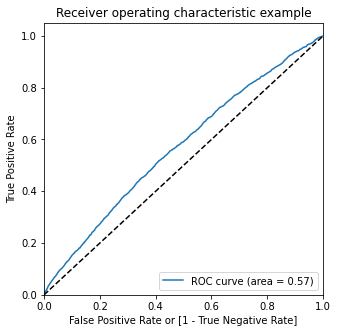

In [74]:
# Roc curve which is desirable and occupying maximum area possible
draw_roc(y_train, y_prob)

In [75]:
mat=pd.DataFrame()

In [76]:
#predicting the target values by using different cut offs
numbers=[float(x)/10 for x in range(10)]
for i in numbers:
    mat[i]=list(map(lambda x: 1 if x> i else 0,y_prob))
mat.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [77]:
numbers=[float(x)/10 for x in range(10)]
numbers

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [79]:
#For different cut offs calculating the metrics
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train, mat[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy  sensi     speci
0.0   0.0  0.042651    1.0  0.000000
0.1   0.1  0.957268    0.0  0.999915
0.2   0.2  0.957349    0.0  1.000000
0.3   0.3  0.957349    0.0  1.000000
0.4   0.4  0.957349    0.0  1.000000
0.5   0.5  0.957349    0.0  1.000000
0.6   0.6  0.957349    0.0  1.000000
0.7   0.7  0.957349    0.0  1.000000
0.8   0.8  0.957349    0.0  1.000000
0.9   0.9  0.957349    0.0  1.000000


we fail to capture the optimum cutoff value for this model lets go ahead with another model see how it goes.

## Modelling: Random Forest

In [80]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import sklearn
from sklearn.ensemble import RandomForestClassifier

In [81]:
cols=X_train.columns
cols

Index(['Age', 'Gender', 'Marital_Status', 'No of dependents', 'Income',
       'Education', 'Profession', 'Type of residence',
       'No of months in current residence', 'No of months in current company'],
      dtype='object')

In [82]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(10,20,2)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='accuracy',return_train_score=True)
rf.fit(X_train[cols], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [ ]:
sklearn.metrics.SCORERS.keys()

In [83]:
# scores of GridSearch CV
scores = rf.cv_results_
sc=pd.DataFrame(scores)
sc.head()

sc[sc['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,1.974978,0.057615,0.192952,0.015883,14,{'max_depth': 14},0.859027,0.8624,0.85596,0.867716,...,0.862152,0.004276,1,0.90081,0.898331,0.895648,0.904133,0.900378,0.89986,0.002811


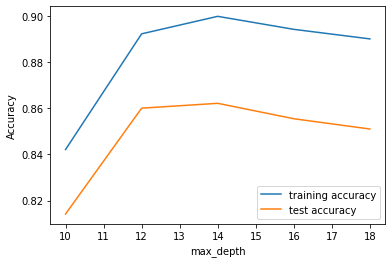

In [84]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [89]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(1,100,10)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='accuracy',return_train_score=True)
rf.fit(X_train[cols], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [90]:
# scores of GridSearch CV
scores = rf.cv_results_
sc=pd.DataFrame(scores)
sc.head()

sc[sc['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,1.068527,0.008603,0.108146,0.002075,51,{'n_estimators': 51},0.853711,0.859027,0.854835,0.85504,...,0.855405,0.001867,1,0.895111,0.890664,0.892044,0.890715,0.891459,0.891998,0.001638


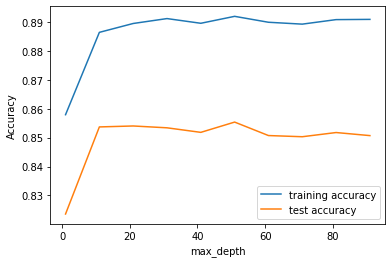

In [91]:
# plotting accuracies with estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [92]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': range(1,10)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='accuracy',return_train_score=True)
rf.fit(X_train[cols], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [93]:
# scores of GridSearch CV
scores = rf.cv_results_
sc=pd.DataFrame(scores)
sc.head()

sc[sc['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,2.970511,0.036165,0.199739,0.000832,6,{'max_features': 6},0.850337,0.85044,0.847986,0.857493,...,0.851704,0.003198,1,0.893654,0.887367,0.889693,0.895852,0.889874,0.891288,0.003045


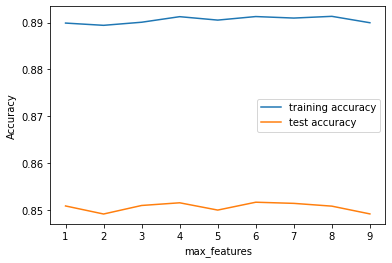

In [94]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [98]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(1,10)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='accuracy',return_train_score=True)
rf.fit(X_train[cols], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [99]:
# scores of GridSearch CV
scores = rf.cv_results_
sc=pd.DataFrame(scores)
sc[sc['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,1.882478,0.023443,0.182949,0.001369,4,{'min_samples_leaf': 4},0.852075,0.858618,0.851973,0.861276,...,0.856877,0.004055,1,0.892938,0.891354,0.892095,0.897411,0.894372,0.893634,0.002138


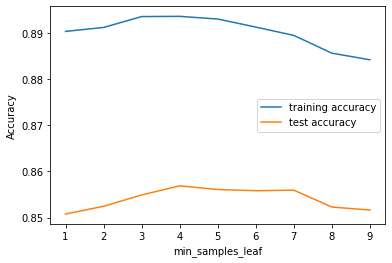

In [100]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [104]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(10,20)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='accuracy',return_train_score=True)
rf.fit(X_train[cols], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [105]:
# scores of GridSearch CV
scores = rf.cv_results_
sc=pd.DataFrame(scores)
sc[sc['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,1.90454,0.01772,0.186689,0.000433,15,{'min_samples_split': 15},0.85504,0.858925,0.851666,0.861889,...,0.858104,0.004238,1,0.896312,0.890613,0.892018,0.896516,0.897848,0.894661,0.002818


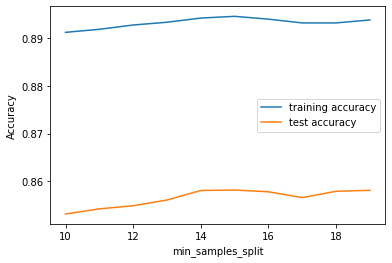

In [106]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
#5,45

In [107]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [12,14],
    'min_samples_leaf': [4,7],
    'min_samples_split': [15],
    'n_estimators': [51], 
    'max_features': [4,6]
}
# Create a based m3
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1)

In [108]:
# Fit the grid search to the data
grid_search.fit(X_train[cols], y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   50.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [109]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)


We can get accuracy of 0.8576948899985538 using {'max_depth': 14, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 51}


In [110]:
rfc = RandomForestClassifier(
                             max_depth=14,
                             min_samples_leaf=4, 
                             min_samples_split=14,
                             max_features=4,
                             n_estimators=51,
                             class_weight='balanced'
                           )
rfc.fit(X_train[cols], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=51,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [111]:
y_train_pred_rf=rfc.predict(X_train[cols])

In [112]:
#Accuracy for the train set with default cuttoff=0.5
round(metrics.accuracy_score(y_train, y_train_pred_rf)*100,2)

88.47

In [113]:
y_prob_rf=rfc.predict_proba(X_train[cols])[:,1]

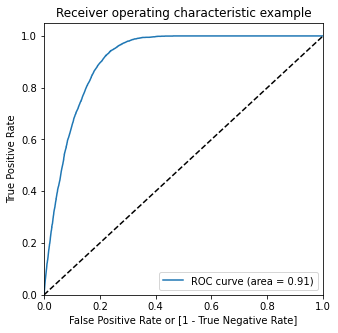

In [114]:
# Roc curve which is desirable and occupying maximum area possible
draw_roc(y_train, y_prob_rf)

##### Here ROC curve looks better than previous model so we can go ahead with this model as final model

In [115]:
mat=pd.DataFrame()

In [116]:
#predicting the target values by using different cut offs
numbers=[float(x)/10 for x in range(10)]
for i in numbers:
    mat[i]=list(map(lambda x: 1 if x> i else 0,y_prob_rf))
mat.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,1,1,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [117]:
#For different cut offs calculating the metrics
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train, mat[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.042876  1.000000  0.000235
0.1   0.1  0.145617  1.000000  0.107554
0.2   0.2  0.406183  1.000000  0.379728
0.3   0.3  0.634260  0.995206  0.618179
0.4   0.4  0.774704  0.934324  0.767593
0.5   0.5  0.884684  0.676414  0.893962
0.6   0.6  0.938846  0.296740  0.967452
0.7   0.7  0.954528  0.077661  0.993593
0.8   0.8  0.957308  0.006711  0.999658
0.9   0.9  0.957349  0.000000  1.000000


In [120]:
#looking at the matrix we can consider the cuttoff to be 0.45
mat[0.45]=list(map(lambda x: 1 if x> 0.45 else 0,y_prob_rf))

In [121]:
cm1 = metrics.confusion_matrix(y_train, mat[0.45] )
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
    
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
cutoff_df.loc[0.45] =[ 0.45 ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy     sensi     speci
0.00  0.00  0.042876  1.000000  0.000235
0.10  0.10  0.145617  1.000000  0.107554
0.20  0.20  0.406183  1.000000  0.379728
0.30  0.30  0.634260  0.995206  0.618179
0.40  0.40  0.774704  0.934324  0.767593
0.50  0.50  0.884684  0.676414  0.893962
0.60  0.60  0.938846  0.296740  0.967452
0.70  0.70  0.954528  0.077661  0.993593
0.80  0.80  0.957308  0.006711  0.999658
0.90  0.90  0.957349  0.000000  1.000000
0.45  0.45  0.835020  0.830297  0.835231


In [122]:
#predicting the target values by using different cut offs
numbers=[float(x)/100 for x in range(40,50)]
for i in numbers:
    mat[i]=list(map(lambda x: 1 if x> i else 0,y_prob_rf))
mat.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.55,0.45,0.41,0.42,0.43,0.44,0.46,0.47,0.48,0.49
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [124]:
numbers=[float(x)/100 for x in range(40,50)]
numbers

[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49]

In [125]:
#For different cut offs calculating the metrics
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49]
for i in num:
    cm1 = metrics.confusion_matrix(y_train, mat[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy     sensi     speci
0.40  0.40  0.774704  0.934324  0.767593
0.41  0.41  0.786992  0.921860  0.780984
0.42  0.42  0.800814  0.899808  0.796403
0.43  0.43  0.812488  0.882071  0.809389
0.44  0.44  0.822446  0.864334  0.820580
0.45  0.45  0.835020  0.830297  0.835231
0.46  0.46  0.847145  0.800575  0.849219
0.47  0.47  0.855773  0.772771  0.859471
0.48  0.48  0.862541  0.749281  0.867586
0.49  0.49  0.872825  0.717641  0.879739


In [126]:
X_test=df_test_woe

In [127]:
#predicting the target variable with test set
y_test_proba=rfc.predict_proba(X_test[cols])[:,1]

In [137]:
y_test_pred=pd.Series(map(lambda x: 1 if x> 0.45 else 0,y_test_proba))

In [138]:
cm1 = metrics.confusion_matrix(y_test, y_test_pred )
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
    
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])

print('Test set confusion matrix')
print(accuracy,sensi,speci)


Five important predictors impacting the performace tag variable when only demographic data is used are Income,Profession,No of dependents,No of months in current company.
Model based on demographic data worked better at predicting good customers with 80% accuracy rather than predicting defaulters.

#### Joining the demographic data and credit bureau data to form master data table

In [39]:
#Joing the data
demo_crd=pd.merge(df_dmg,crd_buro,how='left',on=['Application ID'])

In [40]:
#Removing duplicate columns
demo_crd.drop(['Performance Tag_y'],axis=1,inplace=True)

In [41]:
#Rename the columns
demo_crd.rename(columns={'Performance Tag_x':'Performance Tag'},inplace=True)

In [42]:
# Putting feature variable to X
X = demo_crd.drop(['Performance Tag','Application ID'],axis=1)


# Putting response variable to y
y = demo_crd['Performance Tag']


In [43]:
#Storing the columns in a variable
demo_crd_col=X.columns

In [44]:
# Train test split of the data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=2000)

In [45]:
#Using Weight of evidence technique to create monotonic bins and alos filling the null values
clf1 = WOE()
clf1.fit(X_train, y_train.astype(float))


WOE(exclude_features=None, feature_names='all', mono_cardinality_cutoff=5,
    mono_custom_binning={'Age': array([15., 40., 50., 65.]),
                         'Avgas CC Utilization in last 12 months': array([  0.,  10.,  32., 104.]),
                         'Income': array([-0.5, 18. , 35. , 60. ]),
                         'No of Inquiries in last 12 months (excluding home & auto loans)': array([ 0.,  1.,  4., 20.]),
                         'No of Inquiries in last 6 months (excluding home & auto loans)':...
              'Total No of Trades': {Interval(-0.001, 4.0, closed='right'): -0.6777316071427391,
                                     Interval(4.0, 8.0, closed='right'): 0.21567820692439132,
                                     Interval(8.0, 22.0, closed='right'): 0.32583983580062},
              'Type of residence': {'Company provided': 0.10131635813407336,
                                    'Living with Parents': 0.134167317828836,
                                    'Other

In [46]:
#Copying the woe transformed train data into new data frame
X_train_w=clf1.transform(X_train)

In [47]:
#Copying the woe transformed train data into new data frame
X_test_w=clf1.transform(X_test)
#Changing the datatypes to float
X_test_w=X_test_w.astype(float)

#### Using Voting selector for identifying important variables

In [48]:
#Traing the data with voting selector model
from xverse.ensemble import VotingSelector

clf2 = VotingSelector()
clf2.fit(X_train_w[demo_crd_col], y_train)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=13,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [49]:
#Feature importance by each seelection technique
vb_prob_sel=clf2.feature_importances_

In [50]:
#Using information value identifying the strong predictors but from 
#below code it is evident that there are no strong predictors which is iv value greater that 0.3
vb_prob_sel[['Variable_Name','Information_Value']]
print('Medium PREDICTORS ', vb_prob_sel[vb_prob_sel['Information_Value']>0.1]['Variable_Name'])

Medium PREDICTORS  0               Avgas CC Utilization in last 12 months
1                No of trades opened in last 12 months
2    No of Inquiries in last 12 months (excluding h...
3        No of times 30 DPD or worse in last 12 months
4                                   Total No of Trades
5         No of times 90 DPD or worse in last 6 months
6                 No of trades opened in last 6 months
7         No of times 30 DPD or worse in last 6 months
8        No of times 60 DPD or worse in last 12 months
9                                  Outstanding Balance
Name: Variable_Name, dtype: object


In [51]:
#Copy the votes of the features into a new datframe
vb_sel=clf2.feature_votes_[['Variable_Name','Information_Value','Recursive_Feature_Elimination']]

In [52]:
#Considering the variables favoured by rfe selection technique
col_dc=vb_sel[(vb_sel['Recursive_Feature_Elimination']==1)]['Variable_Name']

In [53]:
#Calculating VIF sequenctially and removing high vif variables
col=col_dc
c=0
while c==0:
    vif = pd.DataFrame()
    vif['Features'] = X_train_w[col].columns
    vif['VIF'] = [variance_inflation_factor(X_train_w[col].values, i) for i in range(X_train_w[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    col=[i for i in col if i not in vif[vif['VIF']==vif['VIF'].max()]['Features'].values]
    #if vif['VIF'].max()<10:
    c=1
vif

,Features,VIF
4,No of trades opened in last 12 months,2.97
1,No of Inquiries in last 12 months (excluding h...,2.71
3,No of times 90 DPD or worse in last 6 months,2.20
2,No of times 30 DPD or worse in last 12 months,2.15
0,Avgas CC Utilization in last 12 months,1.81
9,No of months in current residence,1.08
10,No of months in current company,1.03
7,Age,1.02
11,Type of residence,1.02
5,Gender,1.00


In [54]:
# Logistic regression model with new columns and removing columns whose p value is greater than 0.01
logm1 = sm.GLM(y_train,(sm.add_constant(X_train_w[col_dc])), family = sm.families.Binomial())
df=logm1.fit().summary().tables[1]
dfs=pd.read_html(df.as_html())
dfs=dfs[0]
dfs.columns=dfs.loc[0,:]
dfs.drop(0,axis=0,inplace=True)
# filtered column list is stored in col variable
col=dfs[dfs['P>|z|'].astype(float)<0.1][dfs.columns[0]].values


In [55]:
#Removing the const column as we are uing sklearn logisticg model further
col=[i for i in col if i !='const']

In [56]:
#Training the logist model
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train_w[col], y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
# Using grid search to find best parameters 

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight='balanced')

# hyperparameter space
params = {'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc')

In [58]:
# fit model
model.fit(X_train_w[col], y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [59]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.6743448878090413
Best hyperparameters:  {'C': 0.1, 'penalty': 'l2'}


In [60]:
# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight='balanced',C=0.1,penalty='l2')
logistic.fit(X_train_w[col], y_train)


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
#predicting the target values by using different cut offs
X_train_w['proba']=logistic.predict_proba(X_train_w[col])[:, 1]
numbers=[float(x)/20 for x in range(20)]
for i in numbers:
    X_train_w[i]=X_train_w.proba.map(lambda x: 1 if x> i else 0)
X_train_w.head()

,Age,Gender,Marital_Status,No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,...,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
50868,0.065178,-0.043852,0.025120,0.020100,0.193278,-0.046634,-0.016491,-0.006602,0.086179,-0.065391,...,0,0,0,0,0,0,0,0,0,0
45205,-0.035977,0.013168,-0.004417,0.031983,-0.005080,-0.046634,0.071213,-0.006602,-0.045546,-0.106814,...,1,0,0,0,0,0,0,0,0,0
22506,0.065178,0.013168,-0.004417,0.031983,-0.005080,-0.046634,-0.016491,0.000019,-0.045546,-0.106814,...,0,0,0,0,0,0,0,0,0,0
46195,-0.035977,0.013168,-0.004417,0.020100,0.193278,-0.066288,-0.016491,-0.006602,0.086179,-0.065391,...,1,0,0,0,0,0,0,0,0,0
7133,0.065178,0.013168,-0.004417,-0.026905,-0.005080,0.010343,-0.022009,-0.006602,0.086179,0.145639,...,0,0,0,0,0,0,0,0,0,0


In [62]:
#For different cut offs calculating the metrics
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [float(x)/20 for x in range(20)]
for i in num:
    cm1 = metrics.confusion_matrix(y_train, X_train_w[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy     sensi     speci
0.00  0.00  0.041993  1.000000  0.000000
0.05  0.05  0.041993  1.000000  0.000000
0.10  0.10  0.041993  1.000000  0.000000
0.15  0.15  0.041993  1.000000  0.000000
0.20  0.20  0.041993  1.000000  0.000000
0.25  0.25  0.184900  0.955696  0.151113
0.30  0.30  0.275673  0.924537  0.247231
0.35  0.35  0.360579  0.885102  0.337587
0.40  0.40  0.409216  0.844206  0.390149
0.45  0.45  0.480077  0.783836  0.466762
0.50  0.50  0.569624  0.693281  0.564203
0.55  0.55  0.690021  0.551120  0.696110
0.60  0.60  0.787050  0.391431  0.804392
0.65  0.65  0.838264  0.295034  0.862076
0.70  0.70  0.904013  0.129990  0.937941
0.75  0.75  0.957987  0.000000  0.999979
0.80  0.80  0.958007  0.000000  1.000000
0.85  0.85  0.958007  0.000000  1.000000
0.90  0.90  0.958007  0.000000  1.000000
0.95  0.95  0.958007  0.000000  1.000000


#### As we can see the AUC of the logistic model is very less that is 67 percent so moving to random forest

In [63]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score


In [64]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(2, 10, 50),
    'min_samples_split': range(2, 10, 50),
    'n_estimators': [5,10,20], 
    'max_features': [4,5, 10]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced',random_state=4)
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = folds, n_jobs = -1,verbose = 1)

In [65]:
#Model Fit
grid_search.fit(X_train_w[demo_crd_col], y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   42.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=4,
                                   

In [66]:
# print best hyperparameters
print("Best AUC: ", grid_search.best_score_)
print("Best hyperparameters: ", grid_search.best_params_)

Best AUC:  0.805205592725881
Best hyperparameters:  {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}


#### AUC of the model using random forest is about 80%

In [67]:
# Running the random forest with best parameters.
rfc = RandomForestClassifier(class_weight='balanced',random_state=4,
                             max_depth= 10, max_features= 10, min_samples_leaf= 2, 
                             min_samples_split= 2, n_estimators= 20)
rfc.fit(X_train_w[demo_crd_col], y_train)
y_pred = rfc.predict(X_train_w[demo_crd_col])

In [68]:
# Calculating the predicted values of xtrain and saving them
y_pred_proba = rfc.predict_proba(X_train_w[demo_crd_col])
X_train_w['pred_proba']=y_pred_proba[:,1]
y_pred=X_train_w.pred_proba.map(lambda x : 1 if x>=0.52 else 0)

In [69]:
# Accuracy of train sub set
print(confusion_matrix(y_train,y_pred))
print(accuracy_score(y_train,y_pred))

[[39551  7308]
 [  671  1383]]
0.8368736327765625


In [70]:
#predicting the target values by using different cut offs
numbers=[float(x)/20 for x in range(20)] 
for i in numbers:
    X_train_w[i]=X_train_w.pred_proba.map(lambda x: 1 if x> i else 0)
X_train_w.head()

,Age,Gender,Marital_Status,No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,pred_proba
50868,0.065178,-0.043852,0.025120,0.020100,0.193278,-0.046634,-0.016491,-0.006602,0.086179,-0.065391,...,0,0,0,0,0,0,0,0,0,0.542490
45205,-0.035977,0.013168,-0.004417,0.031983,-0.005080,-0.046634,0.071213,-0.006602,-0.045546,-0.106814,...,0,0,0,0,0,0,0,0,0,0.517615
22506,0.065178,0.013168,-0.004417,0.031983,-0.005080,-0.046634,-0.016491,0.000019,-0.045546,-0.106814,...,0,0,0,0,0,0,0,0,0,0.262158
46195,-0.035977,0.013168,-0.004417,0.020100,0.193278,-0.066288,-0.016491,-0.006602,0.086179,-0.065391,...,0,0,0,0,0,0,0,0,0,0.473294
7133,0.065178,0.013168,-0.004417,-0.026905,-0.005080,0.010343,-0.022009,-0.006602,0.086179,0.145639,...,0,0,0,0,0,0,0,0,0,0.165408


In [71]:
#For different cut offs calculating the metrics
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [float(x)/20 for x in range(20)]
for i in num:
    cm1 = metrics.confusion_matrix(y_train, X_train_w[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy     sensi     speci
0.00  0.00  0.041993  1.000000  0.000000
0.05  0.05  0.045877  1.000000  0.004055
0.10  0.10  0.075420  1.000000  0.034892
0.15  0.15  0.138143  0.999026  0.100408
0.20  0.20  0.225175  0.995618  0.191404
0.25  0.25  0.332815  0.981013  0.304403
0.30  0.30  0.415861  0.946933  0.392582
0.35  0.35  0.498988  0.920156  0.480527
0.40  0.40  0.598246  0.885589  0.585651
0.45  0.45  0.708401  0.811587  0.703878
0.50  0.50  0.803202  0.724440  0.806654
0.55  0.55  0.881872  0.606621  0.893937
0.60  0.60  0.933821  0.436222  0.955633
0.65  0.65  0.955308  0.255599  0.985979
0.70  0.70  0.960665  0.111490  0.997887
0.75  0.75  0.959234  0.030672  0.999936
0.80  0.80  0.958109  0.002434  1.000000
0.85  0.85  0.958007  0.000000  1.000000
0.90  0.90  0.958007  0.000000  1.000000
0.95  0.95  0.958007  0.000000  1.000000


#### By considering the above cut off data frame we chose 0.52 as the desirable cutoff

In [72]:
# Calculating the predicted values of xtrain and saving them
y_pred_proba_tst = rfc.predict_proba(X_test_w[demo_crd_col])
X_test_w['pred_proba']=y_pred_proba_tst[:,1]
y_pred=X_test_w.pred_proba.map(lambda x : 1 if x>=0.52 else 0)

In [73]:
# Accuracy of train sub set
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[16600  3468]
 [  623   272]]
0.8048466345465821


In [74]:
#Accuracy,sensitivity,specificty of the test data
cm=confusion_matrix(y_test,y_pred)
total=sum(sum(cm))
accuracy = (cm[0,0]+cm[1,1])/total
    
speci = cm[0,0]/(cm[0,0]+cm[0,1])
sensi = cm[1,1]/(cm[1,0]+cm[1,1])
print(accuracy,sensi,speci)

0.8048466345465821 0.3039106145251397 0.8271875622882201


#### As per the business requirement we need to identify customers having no default so preferred specificity over sensitivty

### Application score card

In [75]:
# Calculating application score for train data
#To accomadate the high value of score card to non defaulters modifed the log odd formulae accordingly
X_train_w['app_score']=400+20*(np.log((1-X_train_w['pred_proba'])/X_train_w['pred_proba']))/np.log(2)

In [76]:
#Creating train score card with nexessary columns
score_card_train=pd.merge(demo_crd['Application ID'],X_train_w[['app_score','pred_proba']],how='inner',left_index=True,right_index=True)
score_card_train=pd.merge(score_card_train,y_train,left_index=True,right_index=True)

In [77]:
score_card_train.head()

,Application ID,app_score,pred_proba,Performance Tag
0,954457215,483.394160,0.052639,0.0
1,432830445,469.612254,0.082219,0.0
3,392161677,476.162476,0.066634,0.0
4,182011211,461.299852,0.106739,0.0
5,312196805,449.973208,0.150340,0.0


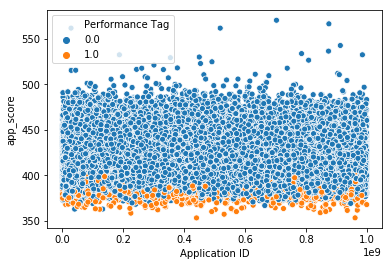

In [78]:
#Scatter plot for train score card
sns.scatterplot(x="Application ID", y="app_score",
                     hue="Performance Tag", data=score_card_train)

#### Inference: As defaulters are below 375 and very good customers are above 450

In [79]:
## Calculating application score for test data
X_test_w['app_score']=400+20*(np.log((1-X_test_w['pred_proba'])/X_test_w['pred_proba']))/np.log(2)

In [80]:
#Creating test score card with nexessary columns
score_card_test=pd.merge(demo_crd['Application ID'],X_test_w[['app_score','pred_proba']],how='inner',left_index=True,right_index=True)
score_card_test=pd.merge(score_card_test,y_test,left_index=True,right_index=True)

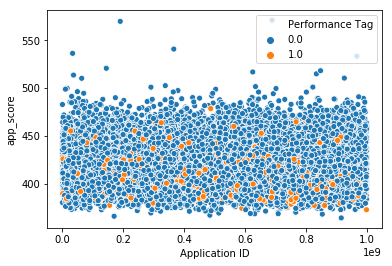

In [81]:
#Scatter plot for train score card

sns.scatterplot(x="Application ID", y="app_score",
                     hue="Performance Tag", data=score_card_test)

In [82]:
#Credit score at the cutoff value 0.52
print('credit card score of the cutoff ',400+20*np.log(0.48/0.52)/np.log(2))

credit card score of the cutoff  397.69045565160127
